<a href="https://colab.research.google.com/github/mickymags/curriculum_development_initiative/blob/main/HYDRAFloods/HYDRAFloods_Module_3_SAR_Surface_Water_Mapping_%5B'22_'23%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

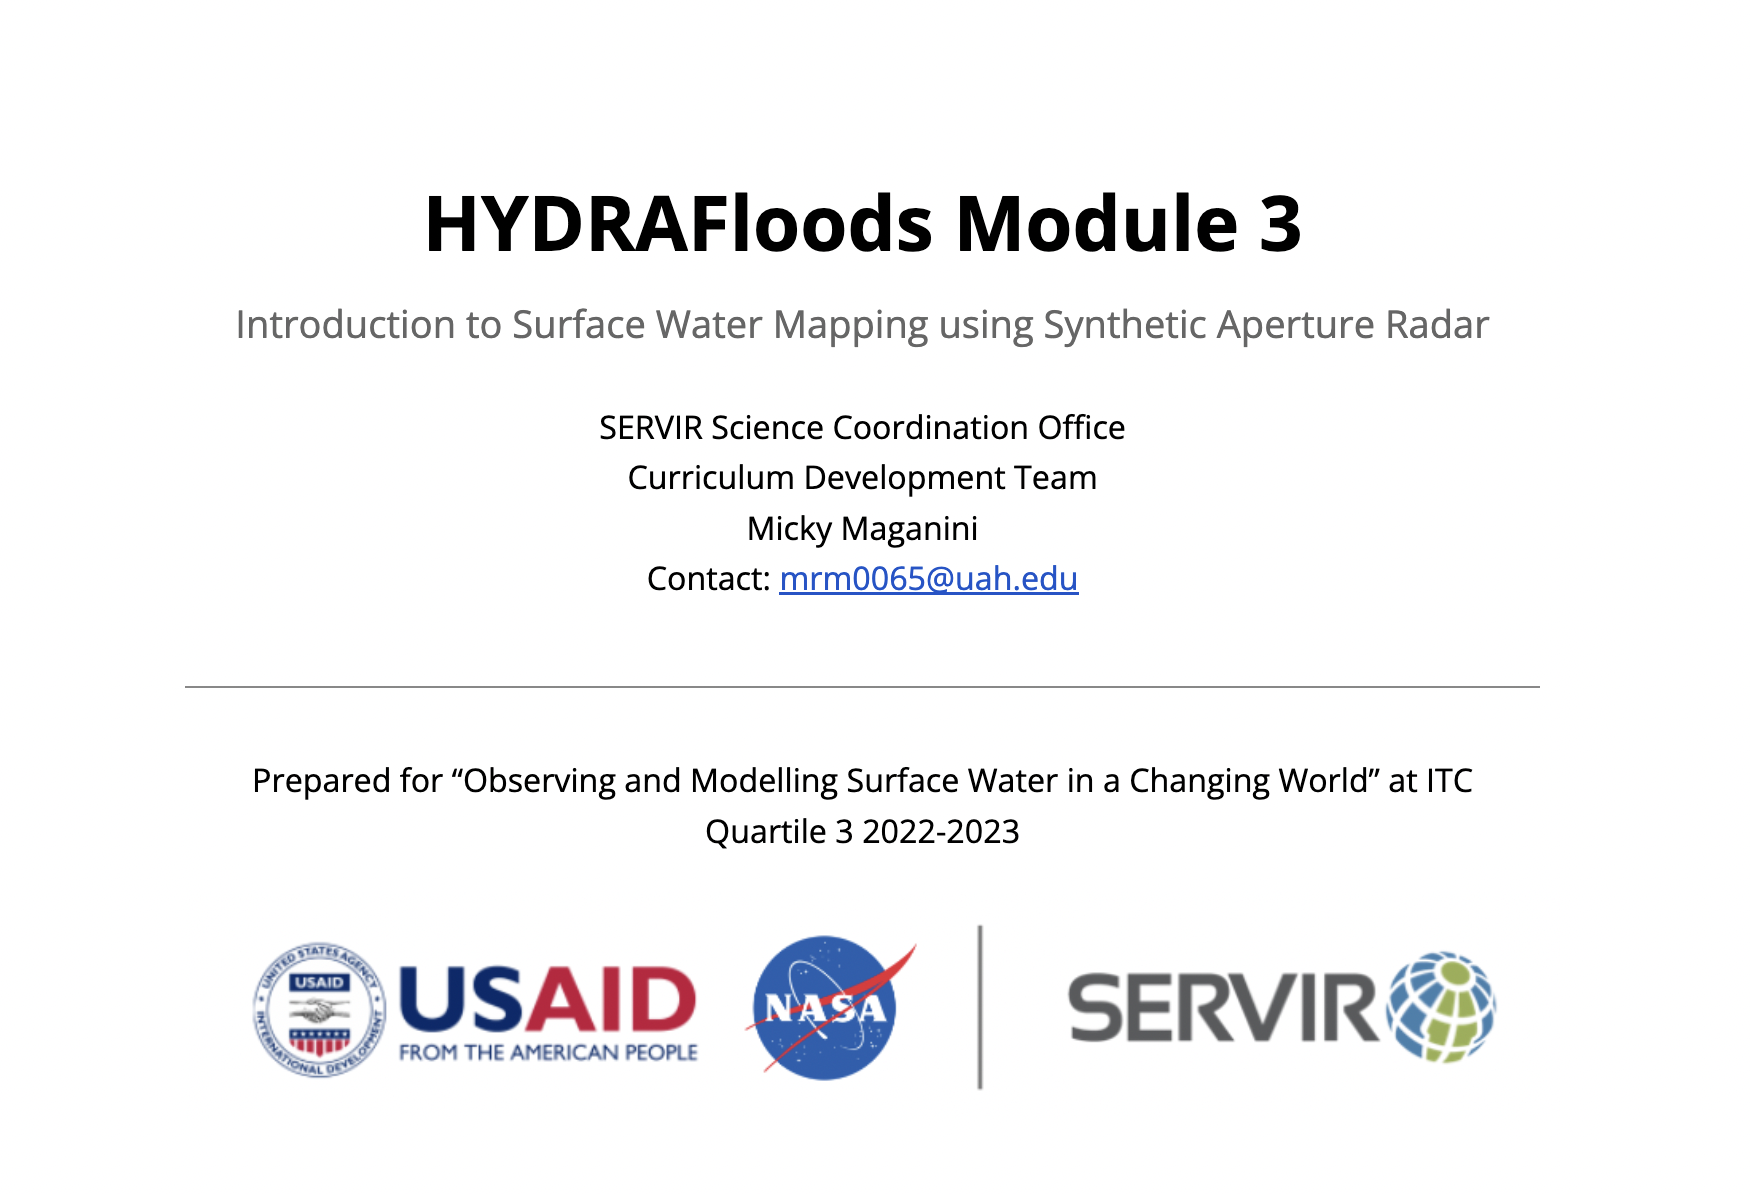

# Prerequisites and Requirements


### Requirements
For this module, you will need a...

* Computer
* A moderately fast internet connection
  * If your internet connection is not very fast, some of the code cells may return errors when run. Reference the [supplementary material for module 2](https://docs.google.com/document/d/1c33JPm0eANXR_SyzOEPeG2BBSSVDWZHCaFePsK3cuYQ/edit?usp=sharing) to view errors and their solutions.
* a Google Earth Engine Account
* Membership of the "hydrafloods-for-itc" Google Cloud Project

### Prerequisites

Before taking this module, it is required that you take [HYDRAFloods Module 1,](https://docs.google.com/document/d/1wZnkCwEVj9vB2YuHw2Uq1VamHk-et7eeqEiY1Ffk_uE/edit?usp=sharing) which will show you how to register a Google Earth Engine account and join the "hydrafloods-for-itc" Google Cloud Project. It is also required that you take [HYDRAFloods Module 2](https://colab.research.google.com/drive/1e2MtldGOOMy9po3zOOGP5pwkXzzw62Co?usp=sharing), which will introduce you to surface water mapping using optical imagery.

# Learning Objectives

By the end of this module, you will...


*   Understand how water reacts to a radar signal
*   Know the three types of scattering surfaces we use to approximate the Earth's surface (and know which one best represents water).
*   Understand how different polarizations of SAR data have different scattering strengths depending on the imaged surface.
*   Understand how automated thresholding algorithms work and how to implement them in HYDRAFloods
*   Be able to apply speckle filtering and terrain correction to SAR data
*   Be able to perform a complete SAR surface water mapping workflow using HYDRAFloods.

---

In this Notebook, we will conduct the following workflow in order to quantify the surface water change of two lakes, Lake Naivasha in Kenya and Lake Xau in Botswana.

1. Define Time Period of Interest
2. Define Region of Interest
3. Obtain Synthetic Aperture Radar Data
4. Pre-process Synthetic Aperture Radar Data
  - Speckle Filtering
  - Terrain Correction
5. Use a thresholding algorithm to create a binary water image
7. Use an Earth Engine Reducer to determine the surface area change of the lake

# **Step 1: Make a Copy of This Notebook**

Towards the top of this page, click **File** --> **Save a copy** in Drive in order to make a personal copy of this notebook. You can then follow along in your personal notebook for the rest of the module and play around with the code as you wish. Click **File** --> **Save** regularly to save your progress.

---

# **Step 2: Install HYDRAFloods**

Our first step whenever we work with HYDRAFloods is to install the HYDRAFloods package. We have to run this everytime we want to use HYDRAFloods.

We can install hydrafloods using `!pip install` as we will see in the following code cell. We will simultaneously install the `geemap` module, which we will use to visualize our data from Google Earth Engine within this notebook.

In [ ]:
!pip install hydrafloods geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=53c9d9dc456bb20f3e0f28a45c8a41bd0047a7274b4d0f30041d2ea35a539a2d
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
  Created wheel for pipetools: filename=pipetools-1.1.0-py3-none-any.whl size=13601 sha256=5e545c464c18814dd3621db6641f45984e4640e8078220ef6c94a24846b1ee1f
  Stored in directory: /root/.cache/pip/wheels/3e/66/b3/357ae471d72e8b2fabf98f8395730c146e15c2be70c4c8c361

Now that we have installed our packages, it's time to import them so we can use them in this notebook using `import`.

In [ ]:
import geemap
import geemap.colormaps as cm
import ee
import hydrafloods as hf
from hydrafloods import corrections     # import the corrections module of hydrafloods, which we will use to preprocess our data

Now, we have to authenticate and initialize earth engine. Before running the code below, [click here](https://docs.google.com/document/d/1-cfsfzYvYE9yR6kApeEa0ovnp01vXMmMQpDv1WlWBaY/edit?usp=sharing) to view the supplementary material for this module. It is recommeneded that you have this document open in a separate window, as it will walk you through the authentication process that is triggered by running the cell below.

In [ ]:
ee.Authenticate()

ee.Initialize(project = "servir-sco-assets")

Next, we will run the `Map` module of `geemap` to allow us to view the earth engine interface within this notebook.

In [ ]:
_ = geemap.Map()

Finally, we want to check what version of HYDRAFloods to make sure we are running the latest version (which is "2021.10.11").

In [ ]:
hf.__version__

'2023.10.14'

---
# **Step 3: Acquire Data**

First, we want to use `ee.Geometry.Polygon` to define our region of interest, which will be Lake Naivasha, just like in module 2. Then, we will define two time periods of interest, one in 2017, and one in 2022.

In [ ]:
# define region of interest using ee.Geometry.Polygon
roi_naiv = ee.Geometry.Polygon(
    [[[36, -1],                               # Enter coordinate pairs as a one-dimensional list: [longitude, latitude]
    [36, 0],
    [37, 0],
    [37, -1]]]
)

# Define start and end time for initial time period
start_time_alpha = "2017-04-01"
end_time_alpha = "2017-07-01"

# Define start and end time for secondary time period
start_time_beta = "2022-01-01"
end_time_beta = "2022-04-01"

Now we will use `hf.Sentinel1` to get imagery over this region during this time period, and automatically apply some preprocessing functions. As mentioned in module 2, the "API Reference" Section of the [HYDRAFloods Documentation](https://servir-mekong.github.io/hydra-floods/) is helpful whenever using HYDRAFloods methods, and we can view the source code at the [HYDRAFloods Github page](https://github.com/Servir-Mekong/hydra-floods).

In [ ]:
# Define a variable called s1_alpha to get data over Lake Naivasha over initial time period
s1_alpha = hf.Sentinel1(roi_naiv, start_time_alpha, end_time_alpha)

# Define a variable called s1_beta to get data over Lake Naivasha over later time period
s1_beta = hf.Sentinel1(roi_naiv, start_time_beta, end_time_beta)

Next, we will use the `.n_images` method to find out how many images are in each of our datasets. We do this to make sure it doesn't return a 0, which would mean there is no imagery over this region during this time period.

In [ ]:
# Get number of images in s1_alpha
num_alpha = s1_alpha.n_images

# Get number of images in s1_beta
num_beta = s1_beta.n_images

# Print num_alpha and num_beta
print("Number of images over Lake Naivasha in 2017:", num_alpha)
print("Number of images over Lake Naivasha in 2022:", num_beta)

Number of images over Lake Naivasha in 2017: 42
Number of images over Lake Naivasha in 2022: 30


---

# **Step 4: Perform Pre-Processing on Data**

Here we will perform two pre-processing steps on our data, speckle filtering and terrain correction.

### Speckle Filtering
SAR imagery is affected by an artifact called speckle. Speckle looks like "salt-and-pepper" or "TV static" noise, and is caused due to the interference of radar waves reflected from elementary scatterers on the ground. There are three different speckle filter algorithms available in HYDRAFloods, but here we will apply `hydrafloods.gamma_map` after Beauchemin et al., 1995. You may find a link to this publication in the works cited section of this module (located at the bottom) should you wish to delve deeper into these methods. The speckle filtering algorithms and their method names can be found in the following list:

1.   Gamma MAP Algorithm
  * Source: [Beauchemin et al. 1995](https://www.tandfonline.com/doi/abs/10.1080/01431169608949067)
  * Code: `hf.gamma_map`
2.   Lee Sigma Algorithm
  * Source: [Lee et al. 2008](https://ieeexplore.ieee.org/document/4689358)
  * Code: `hf.lee_sigma`)
3.   Refined Lee Algorithm
  *  Source: [Lee 1981](https://linkinghub.elsevier.com/retrieve/pii/S0146664X81800184)
  *  Code: `hf.refined_lee`


### Terrain correction
SAR imagery is fairly sensitive to terrain effects due to the geometric nature of SAR remote sensing. HYDRAFloods offers a slope correction module developed by [Vollrath et al., 2020](https://www.mdpi.com/2072-4292/12/11/1867) to reduce the effects of topography on the data. See the Works Cited section of this notebook towards the bottom of the page to delve more into the methods used for terrin correction in HYDRAFloods.

First, we will apply speckle filtering, then we will apply terrain correction on both datasets. But first, we need a digital elevation model in order to apply terrain corection to our data.

In [ ]:
# Define the elevation dataset we want to perform terrain correction based on.
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM")

# Perform Speckle Filtering on s1_alpha using the gamma MAP algorithm
s1_alpha_speckle = s1_alpha.apply_func(hf.gamma_map)

# Perform Speckle Filtering on s1_beta using the gamma MAP algorithm
s1_beta_speckle = s1_beta.apply_func(hf.gamma_map)

# Perform Terrain Correction on s1_alpha_speckle using the DEM defined above as "elv"
s1_alpha_tc = s1_alpha_speckle.apply_func(corrections.slope_correction,elevation=elv, buffer = 30)

# Perform Terrain Correction on s1_beta_speckle using the DEM defined above as "elv"
s1_beta_tc = s1_beta_speckle.apply_func(corrections.slope_correction,elevation=elv, buffer = 30)

Let's visualize all of the data from 2018, including the original data, the speckle filtered data, and the data with both speckle filtering and terrain correction applied.

To visualize our data from 2018, we will need to apply a temporal reducer to turn our image collections into a single image. In this case we will be using a median reducer. If you need a refresher on temporal reducers, see Step 3 (Acquire Data) of [HYDRAFloods Module 2.](https://colab.research.google.com/drive/1e2MtldGOOMy9po3zOOGP5pwkXzzw62Co?usp=sharing)

In [ ]:
# Apply a median temporal reducer to all three datasets using .collection.median()

# Apply reducer to original data
alpha_og_med = s1_alpha.collection.median()

# Apply reducer to data with speckle filtering applied, but no terrain correction applied
alpha_speck_med = s1_alpha_speckle.collection.median()

# Apply reducer to data with both speckle filtering and terrain correction applied
alpha_tc_med = s1_alpha_tc.collection.median()

Now we want to define some visualization parameters, which include a minimum and maximum value, and the bands to visualize.   But how do we know what bands are in our data?

We can use `.bandNames().getInfo())`, which is a method that can be run on a singular image, to get HYDRAFloods to tell us what bands are available in the Sentinel 1 Data. This will help when we define our visualization parameters. If you need a refresher on visualization parameters, see Step 3 (Acquire Data) of [HYDRAFloods Module 2.](https://colab.research.google.com/drive/1e2MtldGOOMy9po3zOOGP5pwkXzzw62Co?usp=sharing)

In [ ]:
# Print the Band Names for the original Sentinel 1 Data
print("Band names for original Sentinel 1 Data", alpha_og_med.bandNames().getInfo())

Band names for original Sentinel 1 Data ['VV', 'VH', 'angle']


In [ ]:
# Define some visualization parameters

vis_params = {
    "bands": "VV",          # Pick what bands to visualize. In this case we will create a gray scale image with just one band, the VV band.
    "min": -25,             # Set a minimum value of -25
    "max": 0,               # Set a maximum value of 0
    "region": roi_naiv,
    "dimensions": 1500
}

In [ ]:
Map = geemap.Map(center=(-0.755, 36.35), zoom=12)

Map.addLayer(alpha_og_med, vis_params, 'Original Sentinel 1 Dataset')
Map.addLayer(alpha_speck_med, vis_params, 'Speckle Filtered Sentinel 1')
Map.addLayer(alpha_tc_med, vis_params, 'Terrain Corrected and Speckle Filtered')

Map

Map(center=[-0.755, 36.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

# Question 1

Use the Layer Panel in the top right of the above map window (represented by three stacked squares) to turn the layers off and on. What differences can you notice between the original sentinel 1 data, the speckle filtered sentinel 1 data, and the data which has been speckle filtered and terrain corrected?

Enter your answer in the empty text cell below.

In [ ]:
#@title Solution to Question 1: Click "show code" below to see the answer { display-mode: "form" }

# The speckle filtered image appears more blurry than the original image, but has less "TV static" noise than the original image.
# The data that is both speckle filtered and terrain corrected no longer shows the topography that we can observe on the left hand side of the image.
# This allows us to better see the areas that are in the "shadow" due to the topography and geometry of the sensor.

# Question 2:

Can you see the lake in the image? What can you say about the brightness of the image over the lake compared to the brightness over the rest of the image? Why do you think this is occuring? (Hint: See Figure 1 below).

Enter your answer in the empty text cell below.

In [ ]:
#@title Solution for Question 2: Click "Show Code" below to display the answer

# The lake appears dark, almost black whereas the rest of the image is gray or white.

# This is due to the fact that larger values represent white in the image, and lower values represent black.
# Thus, we can conclude that there are lower values over the lake then in other regions.
# Larger values signify that we are getting a strong return signal to the sensor.
# Other rough scatterers like bare ground will scatter a portion of our signal away from the sensor,
# but will return some signal to the sensor, resulting in intermediate to high brightness values.

# However, smooth water undergoes specular reflection, which means that the signal is scattered completely away from the signal,
# as shown by the figure below.

### Figure 1: Specular Reflection Versus Diffuse Scattering
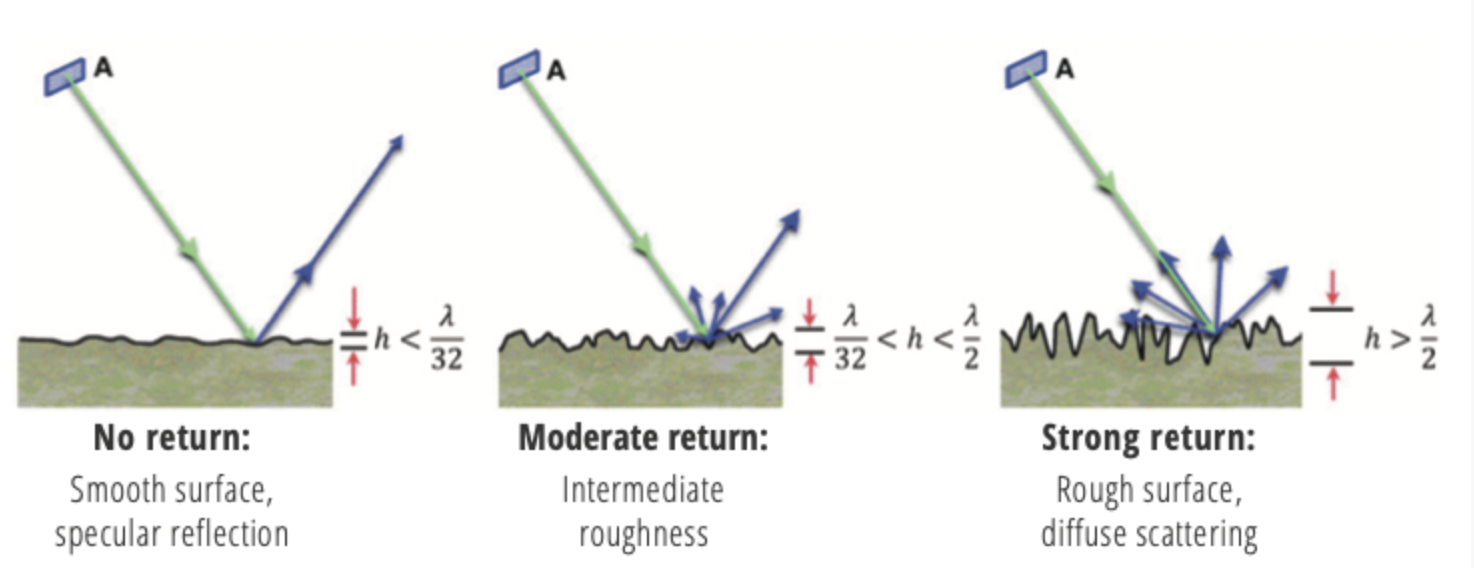

Image Source: [SAR Handbook](https://servirglobal.net/Global/Articles/Article/2674/sar-handbook-comprehensive-methodologies-for-forest-monitoring-and-biomass-estimation)


# Question 3:



Read the information below about Synthetic Aperture Radar (SAR) scattering properties below, then answer the following question:

**Looking at the relative scattering properties, and knowing that water is considered a "Rough Surface Scatter", why do you think we are using the VV band when our objective is to map water?**

You may have noticed that when we specified our visualization parameters above, we only selected the VV band, which stands for "Vertical Vertical" Polarization. SAR sensors often collect data from multiple different polarization types. To learn more about different polarization types, you can [click here](https://hyp3-docs.asf.alaska.edu/guides/introduction_to_sar/#:~:text=There%20are%20four%20different%20polarization,as%20illustrated%20in%20Figure%202.) to visit the Alaska Satellite Facility webpage.

The radar response to the Earth's surface is commonly approximated as three different types of surfaces, rough surface scattering, volume scattering, and double bounce scattering.

You can see an example of the different scattering types below.
1. Rough Surface Scatterers
  - Examples include ground, water, some vegetation
2. Volume Scatterers -- tree canopy
  - Example include tree canopies
3. Double Bounce Scatterers
  - Examples include tree trunks, buildings, and light poles.

### Figure 2: Three Types of Scattering Surfaces
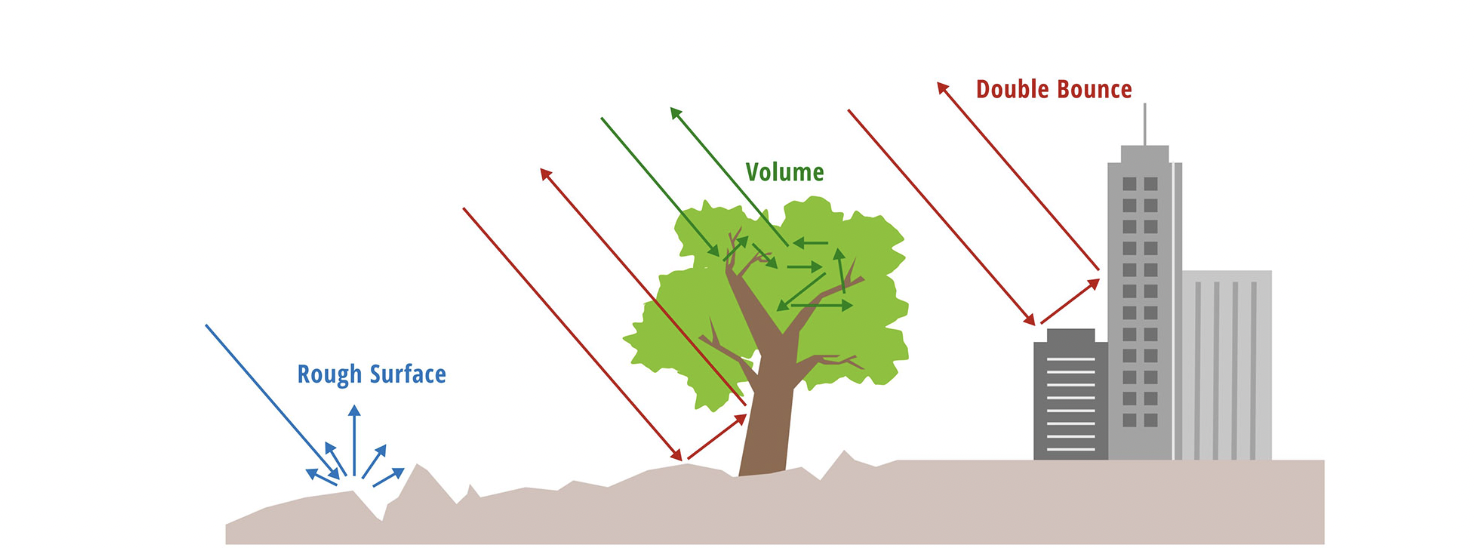

Image Source: [SAR Handbook](https://servirglobal.net/Global/Articles/Article/2674/sar-handbook-comprehensive-methodologies-for-forest-monitoring-and-biomass-estimation)


Each of these three surfaces have different scattering strength for each polarization type(i.e. some surfaces scatter some polarizations stronger than others). We can see the relative scattering strength for different polarizations in Figure 3 below.

### Figure 3: Relative Scattering Strength by Polarization
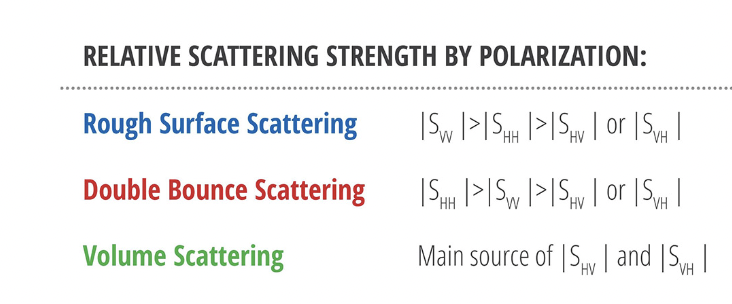


Image Source: [SAR Handbook](https://servirglobal.net/Global/Articles/Article/2674/sar-handbook-comprehensive-methodologies-for-forest-monitoring-and-biomass-estimation)

In [ ]:
#@title Solution for Question 3: Click "Show Code" below to display the answer { display-mode: "form" }

# VV scatters stronger than other bands for rough surface scatterers. Since water and bare land are bouth rough surface scatterers,
# we will receive a strong return for land, and little to no return for water, creating a nice contrast which will make the thresholding process easier.

---
# **Step 5: Use Thresholding Algorithm**

Now, just as we did in module 2, we will use the Edge Otsu Thresholding Algorithm. This will help us to create a binary image of water and land. Earlier in this module, we saw that water will consistently have low radar brightness values, whereas land will have higher radar brightness values.

Instead of using a water index like we did in Module 2, now we will perform thresholding directly on the VV band of our Sentinel 1 data.

There are a couple limitations to this method. One obvious one is that water is not the only thing that specularly reflects. Many manmade surfaces can also show low radar brightness, and these surfaces will be classified as water by our algorithm.

Let's visualize our histogram for the 2017 imagery to make a good guess for our `initial_threshold` parameter.

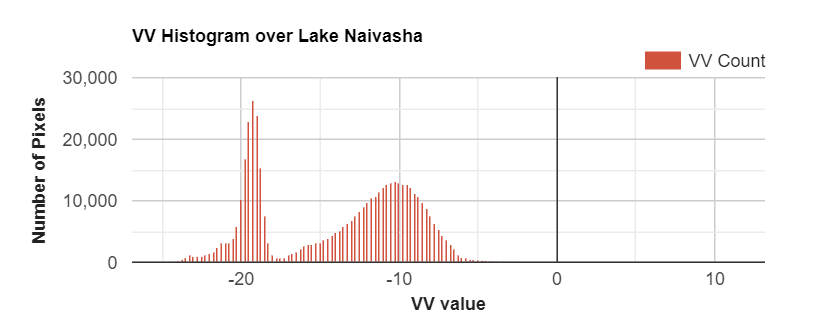

We can see we have a bimodal distribution with one peak close to -19 and another peak closer to -10. So let's set our `initial_threshold` value approximately halfway in between these values, at -15

In [ ]:
# Apply the Edge Otsu Thresholding Algorithm on our data from 2017
edge_alpha = hf.edge_otsu(              # Calling the Edge Otsu Algorithm from HYDRAFloods
    alpha_tc_med,                       # The image to perform thesholding on. This will be the image resulting from the temporally reduced and preprocessed data
    band = "VV",                        # The band to perform thresholding on.
    region = roi_naiv,
    edge_buffer = 300,
    initial_threshold = -15,            # Your intial "guess" for the threshold value. See Figure 4.
    thresh_no_data = 0,                 # Threshold for masked areas.
    scale = 3e2
)

beta_tc_med = s1_beta_tc.collection.median()        # Apply a median temporal reducer on s1_beta_tc.

edge_beta = hf.edge_otsu(
    beta_tc_med,
    band = "VV",
    edge_buffer = 300,
    region = roi_naiv,
    initial_threshold = -15,
    thresh_no_data = 0,
    scale = 3e2
)

In [ ]:
# Make some visualization parameters for water

water_viz = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']   # Set Gray (D3D3D3) to nonwater, and set Navy Blue (000080) to water
}

The below cell may take a while to run (~60 seconds). If you have a particularly slow internet connection, your computation may time out. If this occurs, comment out some of the lines of code using a # at the start of the line and try running it again.

In [ ]:
beta_tc_med = s1_beta_tc.collection.median()        # Apply a median temporal reducer on s1_beta_tc.

edge_beta = hf.edge_otsu(                           # Run the edge otsu thresholding algorithm
    beta_tc_med,                                    # On the sentinel 1 median-reduced image
    band = "VV",                                    # For the VV polarization
    edge_buffer = 300,
    region = roi_naiv,
    initial_threshold = -15,                        # Initial dB value for the algorithm to begin looking for optimal thresh
    thresh_no_data = 0,
    scale = 3e2                                     # spatial resolution at which to display data
)

Map = geemap.Map(center=(-0.755, 36.35), zoom=12)
Map.addLayer(edge_beta, water_viz, 'Water Map 2022')  # Add the water map from  the later time period to the map
Map.addLayerControl()
Map

Map(center=[-0.755, 36.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

# Question 4:

The 2022 water map looks good, but the 2017 shows some false positives. We can see a lot of incorrect detections of water to the Southeast of the lake. Why do you think this is?



In [ ]:
# @title Solution for Question 4, Click "Show Code" below to see the answer.

# We can see that these regions show low radar brightness, even though our optical
# water mapping showed that these regions were not water. If we look at the optical image of this area,
# we can see that many of these areas which are being predicted as water are actually sandy regions.
# Sandy regions that are smooth and flat and do not scatter any SAR signal back to the signal
# are likely to be misclassified as water.
# Thus, we can conclude that regions showing more sandy regions are better suited for optical
# water mapping methods than SAR methods.

# Question 5:

After seeing how to implement HYDRAFloods using both optical and synthetic aperture radar methods, list some examples in the cell below for when you should use synthetic aperture radar methods, and when you should use optical methods.

In [ ]:
# @title Solution for Question 5, Click "Show Code" below to see the answer.

# If cloud cover persists in your area, SAR methods may be better suited as they allow you to "see through" the clouds.
# If your area of interest has sandy regions or other land cover classes that exhibit low radar brightness, optical methods may be the better fit.

---
# **Step 6: Calculate Surface Area Difference**

Just as we did in Module two, we will now use the `discrete_difference` method in HYDRAFloods to create an image where water was detected in the later time period, but not detected in the earlier time period.

In [ ]:
naiv_diff = hf.discrete_difference(edge_beta, edge_alpha)

In [ ]:
view_region = ee.Geometry.Polygon(
  [
    [
      [36.2574165, -0.825466292],
      [36.3614433, -0.83233203],
      [36.40058214, -0.8086452],
      [36.420838191, -0.78186859],
      [36.43045122, -0.755778412],
      [36.42942126, -0.737927146],
      [36.419464900, -0.718016033],
      [36.359751098, -0.70701434],
      [36.3604473649, -0.669038603],
      [36.333496529, -0.6700685],
      [36.319591957, -0.709891052],
      [36.2868046342, -0.72516772],
      [36.2574165, -0.825466292]
  ]
]);

naivasha_px = naiv_diff.eq(1)

naivasha_image = naivasha_px.multiply(ee.Image.pixelArea())

naiv_area = naivasha_image.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = view_region,
    scale = 30,
    maxPixels = 1e13
)

naiv_h20_area = naiv_area.get('flood').getInfo() / 1e6

print("Water Surface Area Change between 2017 and 2022: {0:0.1f} km^2".format(naiv_h20_area))

This is pretty similar to the answer we got in Module 2!

# Exercise 1 -- Corrupted Code

The below code implemented a SAR surface water mapping workflow over Lake Xau, but a cat walked across the keyboard!

It is your job to fill in the missing code -- represented by **XXXXX**. You can pick any times between April 16, 2015, and December of 2021, as these are the dates Sentinel 1 imagery is available over this region.

In [ ]:
# Define region of interest as an Earth Engine Polygon
roi_xau = ee.Geometry.Polygon(
    [
        [24.5188, -21.45],
        [24.5188, -21.2476],
        [24.9, -21.2476],
        [24.9, -21.45]
    ]
)

# Define your intial time period using the "YYYY-MM-DD" format
start_time_a = "XXXX-XX-XX"
end_time_a = "XXXX-XX-XX"

# Define your secondary time period using the "YYYY-MM-DD" format
start_time_b = "XXXX-XX-XX"
end_time_b = "XXXX-XX-XX"

# Get SAR data over this region between your two time periods using hf.Sentinel1
s1_a = hf.Sentinel1(roi_xau, XXXXX_XXXX_X, XXX_XXXX_X)                                 # Get Sentinel 1 data between start_time_a  and start_time_a
s1_b = XX.XXXXXXXXX(XXX_XXX, start_time_b, XXX_XXXX_X)                                 # Get Sentinel 1 data between start_time_b  and start_time_b

# Use n_images to print the number of images in your collection.
print("Number of Sentinel 1 images in initial time period", s1_a.n_images)
print("Number of Sentinel 1 images in later time period", s1_b.n_images)


# Apply speckle filtering to both datasets
speckle_a = XX_X.apply_func(XX.XXXXX_XXX)                                               # Apply speckle filtering to s1_a
speckle_b = XX_X.XXXXX_XXXX(XX.XXXXX_XXX)                                               # Apply speckle filtering to s1_b

# Define a digital elevation model to apply terrain correction based on.
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM")

# Apply terrain correction to both terrain corrected datasets
tc_a = XXXXXXX_X.XXXXX_XXXX(XXXXXXXXXXX.XXXXX_XXXXXXXXXX, elevation = XXX, buffer = 30) # Apply terrain correction to speckle_a
tc_b = speckle_b.XXXXX_XXXX(XXXXXXXXXXX.slope_correction, XXXXXXXXX = XXX, buffer = 30) # Apply terrain correction to speckle_b

# Apply a median reducer to both datasets using .collection.median()
median_a = tc_a.XXXXXXXXXX.XXXXXX()
median_b = tc_b.XXXXXXXXXX.XXXXXX()

# Apply edge otsu thresholding on the median_a image
edge_a = hf.edge_otsu(
    XXXXXX_X,
    band = "VV",
    region = roi_xau,
    edge_buffer = 300,
    initial_threshold = -15,          # May have to change this parameter, values can be between -25 and 0.
    thresh_no_data = 0,
    scale = 30
)


# Apply edge otsu thresholding on the median_b image
edge_b = hf.edge_otsu(
    XXXXXX_X,
    band = "VV",
    edge_buffer = 300,
    region = roi_xau,
    initial_threshold = -15,        # May have to change this parameter, values can be between -25 and 0.
    thresh_no_data = 0,
    scale = 30
)

# Define some visualization parameters for the SAR image.
sar_params = {
    "min": -25,
    "max": 0,
    "bands": "VV",
    "gamma": 1.5,
    "dimensions": 1024
}

# Define some visualization parameters for our water image.
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080'],
    "dimensions": 1024
}

difference = hf.discrete_difference(edge_b, edge_a)                                   # If your later time period has less water than your initial time period, you will need to
                                                                                      # switch the positions of the two parameters (edge_b and edge_a). If not, you
                                                                                      # can keep this code as it appears
###################################################################################
#       NOTE: YOU DO NOT NEED TO CHANGE ANY OF THE CODE BELOW THIS COMMENT        #
###################################################################################

xau_pix = difference.eq(1)

xau_area = xau_pix.multiply(ee.Image.pixelArea())

area_reduced = xau_area.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = roi_xau,
    scale = 30,
    maxPixels = 1e13
)

area_km2 = area_reduced.get('flood').getInfo() / 1e6

print("Water Surface Area change in Lake Xau between initial and later time period: {0:0.3f} km^2".format(area_km2))

Map = geemap.Map(center = (-21.3483, 24.7295), zoom = 12)

Map.addLayer(roi_xau, {}, 'Region of Interest')
Map.addLayer(median_a, sar_params, 'Initial Period SAR Imagery')
Map.addLayer(median_b, sar_params, 'Later Period SAR Imagery')
Map.addLayer(edge_a, water_params, 'Initial Period Water')
Map.addLayer(edge_b, water_params, 'Later Period Water')
Map

Map.addLayerControl()
Map

NameError: ignored

In [ ]:
# @title Solution for Exercise 1, Click "Show Code" below to see the answer.

# Define region of interest as an Earth Engine Polygon
roi_xau = ee.Geometry.Polygon(
    [
        [24.5188, -21.45],
        [24.5188, -21.2476],
        [24.9, -21.2476],
        [24.9, -21.45]
    ]
)

# Define your intial time period using the "YYYY-MM-DD" format
start_time_a = "2017-01-01"
end_time_a = "2017-05-01"

# Define your secondary time period using the "YYYY-MM-DD" format
start_time_b = "2021-01-01"
end_time_b = "2021-05-01"

# Get SAR data over this region between your two time periods using hf.Sentinel1
s1_a = hf.Sentinel1(roi_xau, start_time_a, end_time_a)                                 # Get Sentinel 1 data between start_time_a  and start_time_a
s1_b = hf.Sentinel1(roi_xau, start_time_b, end_time_b)                                 # Get Sentinel 1 data between start_time_b  and start_time_b

# Use n_images to print the number of images in your collection.
print("Number of Sentinel 1 images in initial time period", s1_a.n_images)
print("Number of Sentinel 1 images in later time period", s1_b.n_images)


# Apply speckle filtering to both datasets
speckle_a = s1_a.apply_func(hf.gamma_map)                                               # Apply Gamma MAP speckle filtering to s1_a
speckle_b = s1_b.apply_func(hf.gamma_map)                                               # Apply Gamma MAP speckle filtering to s1_b

# Define a digital elevation model to apply terrain correction based on.
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM")

# Apply terrain correction to both terrain corrected datasets
tc_a = speckle_a.apply_func(corrections.slope_correction, elevation = elv, buffer = 30) # Apply terrain correction to speckle_a
tc_b = speckle_b.apply_func(corrections.slope_correction, elevation = elv, buffer = 30) # Apply terrain correction to speckle_b

# Apply a median reducer to both datasets using .collection.median()
median_a = tc_a.collection.median()
median_b = tc_b.collection.median()

# Apply edge otsu thresholding on the median_a image
edge_a = hf.edge_otsu(
    median_a,
    band = "VV",
    region = roi_xau,
    edge_buffer = 300,
    initial_threshold = -15,          # May have to change this parameter, values can be between -25 and 0.
    thresh_no_data = 0,
    scale = 30
)


# Apply edge otsu thresholding on the median_b image
edge_b = hf.edge_otsu(
    median_b,
    band = "VV",
    edge_buffer = 300,
    region = roi_xau,
    initial_threshold = -15,        # May have to change this parameter, values can be between -25 and 0.
    thresh_no_data = 0,
    scale = 30
)

# Define some visualization parameters for the SAR image.
sar_params = {
    "min": -25,
    "max": 0,
    "bands": "VV",
    "gamma": 1.5,
    "dimensions": 1024
}

# Define some visualization parameters for our water image.
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080'],
    "dimensions": 1024
}

difference = hf.discrete_difference(edge_b, edge_a)                                   # If your later time period has less water than your initial time period, you will need to
                                                                                      # switch the positions of the two parameters (edge_b and edge_a). If not, you
                                                                                      # can keep this code as it appears
###################################################################################
#       NOTE: YOU DO NOT NEED TO CHANGE ANY OF THE CODE BELOW THIS COMMENT        #
###################################################################################

xau_pix = difference.eq(1)

xau_area = xau_pix.multiply(ee.Image.pixelArea())

area_reduced = xau_area.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = roi_xau,
    scale = 30,
    maxPixels = 1e13
)

area_km2 = area_reduced.get('flood').getInfo() / 1e6

print("Water Surface Area change in Lake Xau between initial and later time period: {0:0.3f} km^2".format(area_km2))

Map = geemap.Map(center = (-21.3483, 24.7295), zoom = 12)

Map.addLayer(roi_xau, {}, 'Region of Interest')
Map.addLayer(median_a, sar_params, 'Initial Period SAR Imagery')
Map.addLayer(median_b, sar_params, 'Later Period SAR Imagery')
Map.addLayer(edge_a, water_params, 'Initial Period Water')
Map.addLayer(edge_b, water_params, 'Later Period Water')
Map

Map.addLayerControl()
Map

Number of Sentinel 1 images in initial time period 21
Number of Sentinel 1 images in later time period 19
Water Surface Area change in Lake Xau between initial and later time period: 2.138 km^2


Map(center=[-21.3483, 24.7295], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

# Works Cited
- [Beauchemin et al., 1995](https://www.tandfonline.com/doi/abs/10.1080/01431169608949067), "Optimization of the Gamma-Gamma MAP filter for SAR image clutters", International Journal of Remote Sensing, 17:5, 1063-1067, DOI: 10.1080/01431169608949067.
- [HYDRAFloods Documentation](https://servir-mekong.github.io/hydra-floods/), SERVIR Mekong (now known as SERVIR Southeast Asia) & SERVIR Science Coordination Office.
- [Lee 1981](https://linkinghub.elsevier.com/retrieve/pii/S0146664X81800184), "Refined Filtering of Image Noise using Image Statistics", Volume 15, Issue 4, Pages 380-389, DOI: 10.1016/S0146-664X(81)80018-4.
- [Vollrath et al, 2020](https://www.mdpi.com/2072-4292/12/11/1867), "Angular-Based Radionetric Slope Correction for Sentinel-1 on Google Earth Engine". Remote Sensing, Volume 12, Page 1867. DOI: 10.3390/rs12111867.
- [Introduction to SAR](https://hyp3-docs.asf.alaska.edu/guides/introduction_to_sar/#:~:text=There%20are%20four%20different%20polarization,as%20illustrated%20in%20Figure%202.), Alaska Satellite Facility.


# Acknowledgements

HYDRAFloods was developed by SERVIR-Southeast Asia (formerly known as SERVIR-Mekong). The development team includes Kel Markert, Amanda Markert, Ate Poortinga, Nyein Soe Thwal, Arjen Haag, Farrukh Christie, Tim Mayer, Khun San Aung, Peeranan Towashiraporn, David Saah, Chinaporn Meechaiya, Biplov Bhandari, and Kamal Hosen.

The HYDRAFloods Curriculum was organized by SERVIR’s Science Coordination Office. The modules were influenced by a training developed by Kel Markert, Tim Mayer, Biplov Bhandari, and Lauren Carey and the HYDRAFloods Documentation authored by Kel Markert. Review of the curriculum was conducted by Roelof Rietbroek,  Kelsey Herndon, Emil Cherrington, Diana West, Katie Walker, Lauren Carey, Jacob Abramowitz, Jake Ramthun, Natalia Bermudez, Stefanie Mehlich, Emily Adams, Stephanie Jimenez, Vanesa Martin, Alex Goberna, Francisco Delgado, Biplov Bhandari, and Amanda Markert.

Sources:

SERVIR Application Management System – HYDRAFloods Entry: https://sams.servirglobal.net/detail/19

HYDRAFloods Documentation: https://servir-mekong.github.io/hydra-floods/

